## Markowitz Efficient Frontier

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter as ff
import yfinance as yfin
yfin.pdr_override()

In [2]:
def ticker_frame(tickers, start="2013-01-31", end="2023-01-31", source="yahoo"):
    stock_price = []

    for ticker in tickers:
        price_data = pdr.get_data_yahoo(ticker, start=start, end=end)
        stock_price.append(price_data[["Adj Close"]])
        
    df = pd.concat(stock_price, axis=1)
    df.columns=tickers
    return df

In [3]:
tickers = ['GOOG', 'MSFT', 'NFLX', 'AAPL', 'AMZN']
NUM_STOCKS = len(tickers)
df = ticker_frame(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,GOOG,MSFT,NFLX,AAPL,AMZN
Date,,,,,
2013-01-31,18.821701,22.481112,23.605715,13.930416,13.2750
2013-02-01,19.317593,22.874222,23.542856,13.873228,13.2500
2013-02-04,18.904640,22.472921,24.962856,13.527637,12.9990
2013-02-05,19.072014,22.522058,24.912857,14.002287,13.3445
2013-02-06,19.182350,22.391020,26.344286,13.987306,13.1110


In [5]:
log_returns = np.log(df/df.shift(1))
log_returns.head()

,GOOG,MSFT,NFLX,AAPL,AMZN
Date,,,,,
2013-01-31,NaN,NaN,NaN,NaN,NaN
2013-02-01,0.026006,0.017335,-0.002666,-0.004114,-0.001885
2013-02-04,-0.021609,-0.017700,0.058567,-0.025226,-0.019125
2013-02-05,0.008815,0.002184,-0.002005,0.034486,0.026232
2013-02-06,0.005769,-0.005835,0.055867,-0.001070,-0.017653


In [6]:
np.random.seed(10)
num_ports = 10000
all_weights = np.zeros((num_ports, len(df.columns)))
return_array = np.zeros(num_ports)
volume_array = np.zeros(num_ports)
sharpe_array = np.zeros(num_ports)

In [7]:
for i in range(num_ports):
    weights = np.array(np.random.random(NUM_STOCKS))
    weights = weights/np.sum(weights)
    
    all_weights[i,:] = weights
    return_array[i] = np.sum((log_returns.mean() * weights * 252))
    volume_array[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe_array[i] = return_array[i]/volume_array[i]

In [8]:
print("Max sharpe ratio in the array: {}".format(sharpe_array.max()))
print("Location in the array: {}".format(sharpe_array.argmax()))

Max sharpe ratio in the array: 0.9489366677498501
Location in the array: 4630


In [9]:
max_sharpe_ratio_return = return_array[sharpe_array.argmax()]
max_sharpe_ratio_volume = volume_array[sharpe_array.argmax()]

In [10]:
opt_weights = pd.DataFrame(all_weights[sharpe_array.argmax(), :], index = tickers, columns=["Weight"])
opt_weights

,Weight
GOOG,0.011650
MSFT,0.414608
NFLX,0.150303
AAPL,0.400709
AMZN,0.022731


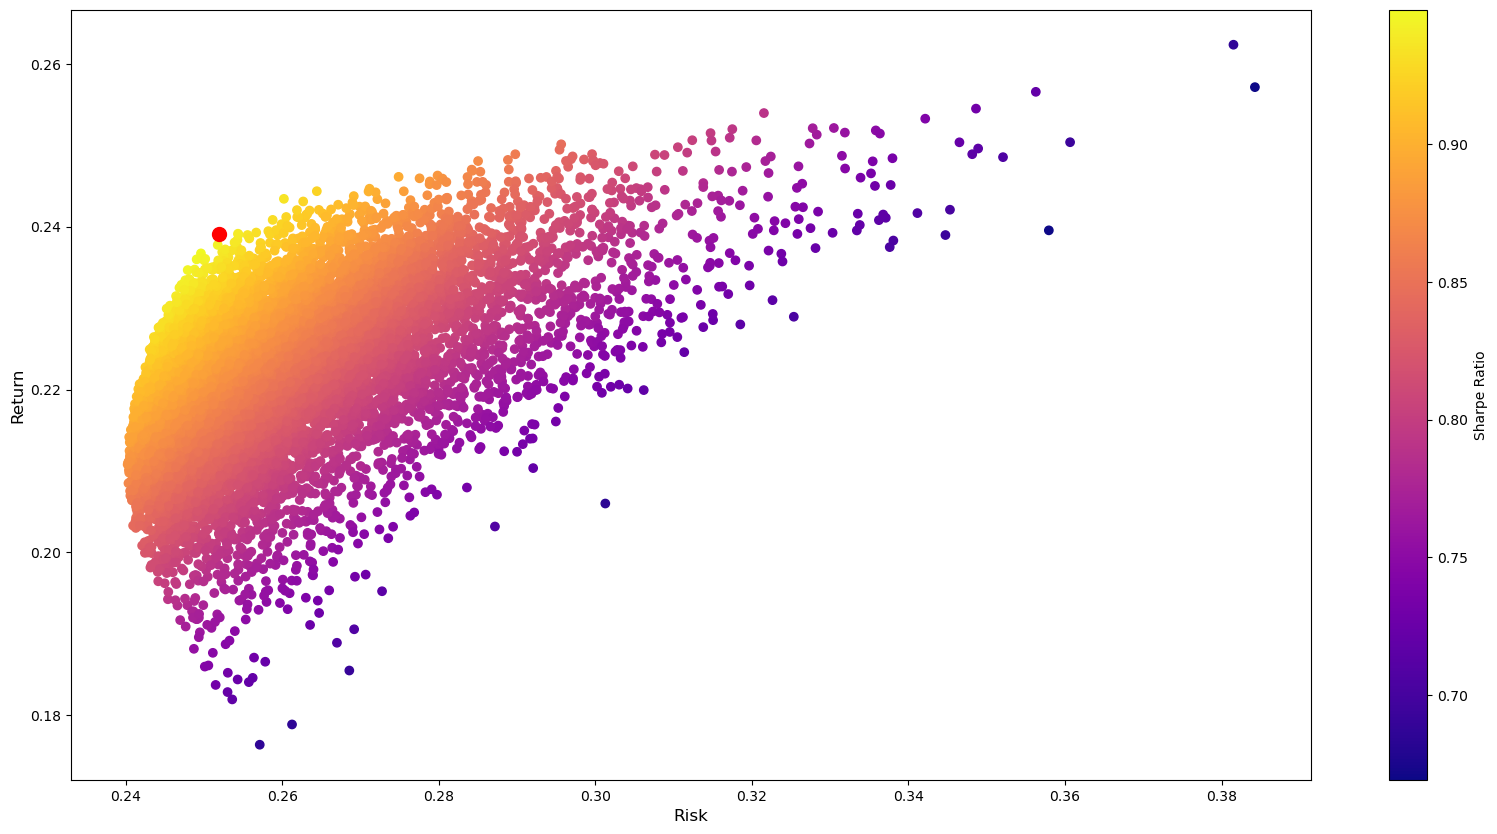

In [11]:
plt.figure(figsize=(20, 10))
plt.scatter(volume_array, return_array, c=sharpe_array, cmap="plasma")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Risk", fontsize=12)
plt.ylabel("Return", fontsize=12)
plt.scatter(max_sharpe_ratio_volume, max_sharpe_ratio_return, c="red", s=100)
plt.show()

In [12]:
def get_return_volume_sharpe_ratio(weights):
    weights = np.array(weights)
    returns = np.sum(log_returns.mean() * weights) * 252
    volume = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe_ratio = returns/volume
    return np.array([returns, volume, sharpe_ratio])

def negative_sharpe_ratio(weights):
    return get_return_volume_sharpe_ratio(weights)[2] * - 1

def check_sum(weights):
    return np.sum(weights)-1

In [13]:
cons = ({"type": "eq", "fun": check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
init_guess = [0.20, 0.20, 0.20, 0.20, 0.20]

In [14]:
def minimize_volatility(weights):
    return get_return_volume_sharpe_ratio(weights)[1]

In [15]:
opt_results = minimize(negative_sharpe_ratio, init_guess, method="SLSQP", bounds=bounds, constraints=cons)
print(opt_results)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.9543111490192184
       x: [ 1.249e-17  5.263e-01  1.257e-01  3.480e-01  1.063e-17]
     nit: 5
     jac: [ 1.007e-01  2.770e-05  3.590e-04 -1.716e-04  1.325e-02]
    nfev: 30
    njev: 5


In [16]:
get_return_volume_sharpe_ratio(opt_results.x)

array([0.24013993, 0.25163693, 0.95431115])

In [17]:
frontier_y = np.linspace(0.18, 0.27, 100)

In [18]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_return_volume_sharpe_ratio(w)[0] - possible_return})
    
    result = minimize(minimize_volatility, init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

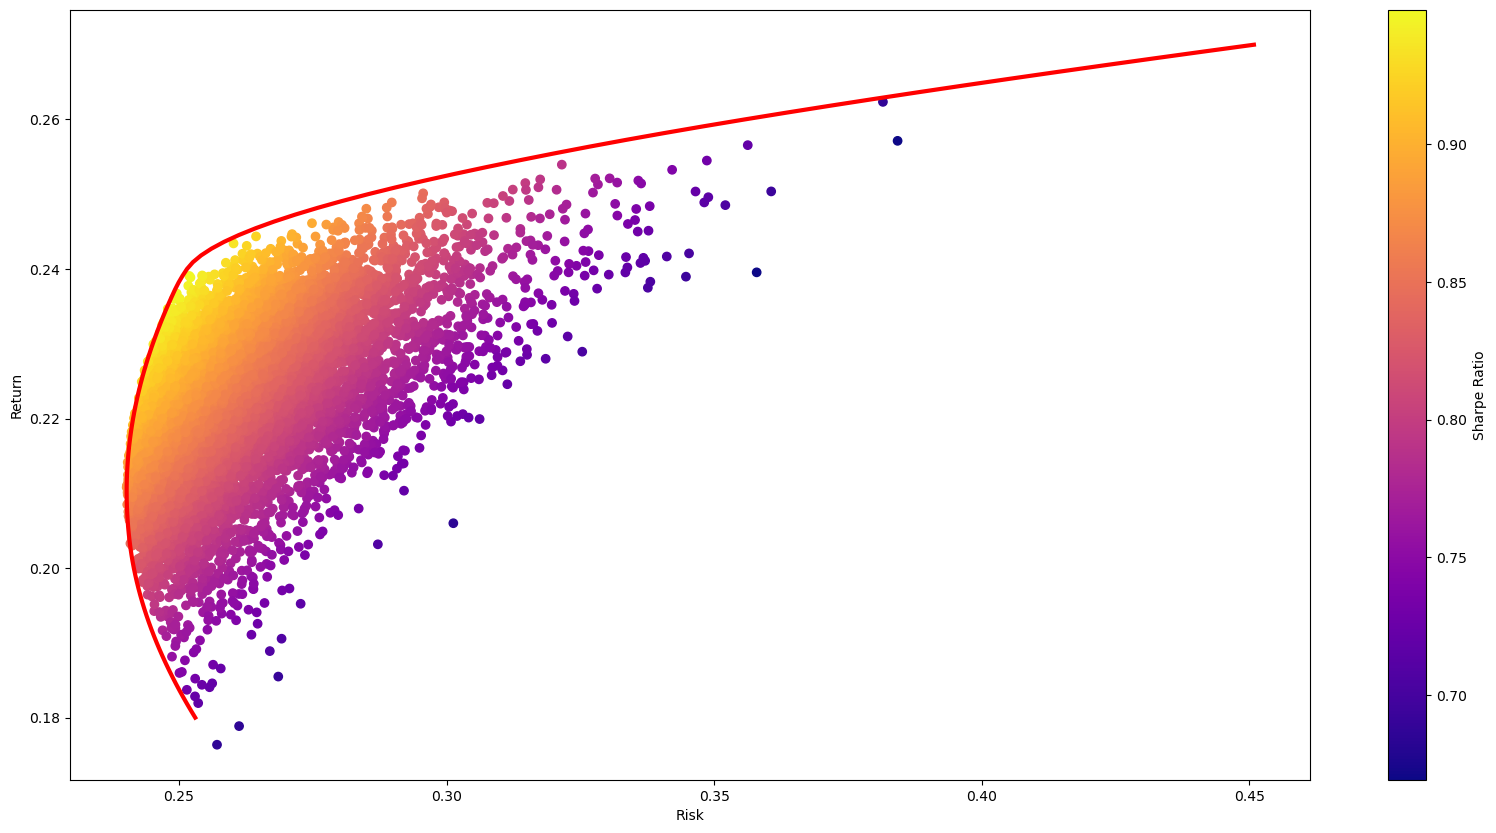

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(volume_array, return_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r', linewidth=3)
plt.savefig('cover.png')
plt.show()